In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!pip install tensorboardX
#!pip install colormap
#!pip install easydev
#!pip install tqdm

In [5]:
import pdb
import sys
import os
import argparse
import logging
import json
import time

import torch
print(f"Torch Version {torch.__version__}")
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn
from torch.nn import BCEWithLogitsLoss, DataParallel
from torch.optim import SGD

from tensorboardX import SummaryWriter

#sys.path.append(os.path.dirname(os.path.abspath(__file__)) + '/../../')

# put this into every cell that makes random choices
torch.manual_seed(42)
print(torch.randn(1))
if torch.cuda.is_available():
  print("GPU is available.")
  torch.cuda.manual_seed_all(42)

#from wsi.data.image_producer import GridImageDataset  # noqa
#from wsi.model import MODELS  # noqa

Torch Version 1.1.0
tensor([0.3367])
GPU is available.


In [6]:
print(torch.randn(1))

tensor([0.1288])


In [7]:
import ntpath
ntpath.basename("a/b/c")
import os
import h5py
import numpy as np
import os
import random
# import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import glob
import skimage.io as io
import skimage.transform as trans
import math
import tqdm

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail or ntpath.basename(head)

Using TensorFlow backend.


In [0]:
import torchvision as tv

# resize h, w to 292 x 438 = 2336 x 3504 / 8 each
toTensor = tv.transforms.ToTensor()
ToPILImage = tv.transforms.ToPILImage()

def get_G_band(img):
  """
  img: pytorch tensor of shape (3, h, w)
  """
  # get green channel/band by setting R and B bands to 0
  img_g = img.clone()
  img_g[0,:,:] = 0
  img_g[2,:,:] = 0
  return img_g

def get_G_band_(img):
  """
  img: pytorch tensor of shape (h, w, 3)
  """
  img_copy = img.clone()
  img_copy[:,:,0] = 0
  img_copy[:,:,2] = 0
  return img_copy

def get_R_band_(img):
  """
  img: pytorch tensor of shape (h, w, 3)
  """
  # get red channel/band by setting other bands to 0
  img_copy = img.clone()
  img_copy[:,:,1] = 0
  img_copy[:,:,2] = 0
  return img_copy

def get_B_band_(img):
  """
  img: pytorch tensor of shape (h, w, 3)
  """
  # get blue channel/band by setting other bands to 0
  img_copy = img.clone()
  img_copy[:,:,0] = 0
  img_copy[:,:,1] = 0
  return img_copy

In [0]:
def extract_gxy(img_ten, debug=False):
  """builds the old shape (#img, h*w, 3) instead of (#img, 3*h*w)
  
  img_g_ten: tensor of shape (3, h, w) [the 3 being the RGB channels], whose R and B bands are either empty or will be ignored by this method
  # output 
  feats: tensor of shape torch.Size([127896, 3]), gxy features * flattened pixels
  """
  # img_ten.shape = (3, h, w)
  _, h, w = img_ten.shape
  if debug:
    print(h, w)
  img_g_ten = get_G_band(img_ten)
  # let's stack up our tensor feature sandwich "feats"!
  g = img_g_ten[1]
  if debug:
    print(g.shape)
  g.unsqueeze_(2)
  if debug:
    print(g.shape)
  x = torch.arange(0, h, dtype=torch.float).repeat_interleave(w).resize(h, w)
  if debug:
    print(x.shape)
  # extend by empty dimension at position 0 so they can be concatenated by that dimension later
  x.unsqueeze_(2)
  if debug:
    print(x.shape)
  y = torch.arange(0, w, dtype=torch.float).repeat(h).resize(h, w)
  if debug:
    print(y.shape)
  y.unsqueeze_(2)
  if debug:
    print(y.shape)
  # dim=0 concatenate among 0-dimension, which all vectors have as they were unsqueezed
  feats = torch.cat((g, x, y), dim=2)
  if debug:
    print(f"feats shape: {feats.shape}")
    print(f"Top left pixel is value {feats[0,0,0]}")
    plt.imshow(feats[:,:,0], cmap='Greys')
    plt.show()
    plt.imshow(feats[:,:,1], cmap='Greys')
    plt.show()
    plt.imshow(feats[:,:,2], cmap='Greys')
    plt.show()
  # shape = features x pixels
  if debug:
    print(feats.shape)
  #feats = feats.view(h, w, 3)  # put tensor back into shape
  return feats


In [0]:
def min_val(tens, *dims):
  """dims have to be in ascending order for this to work
  tens: torch.tensor
  *dims: integers indeces along which to take min
  returns torch.tensor with minima, collapsed along the given dimensions"""
  if len(dims) > tens.dim():
    raise Exception("len(dims) > tens.dim()")
  if len(dims) == 1:
    return tens.min(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0])
  elif len(dims) == 2:
    r = tens.min(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).min(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1])
    return r
  elif len(dims) == 3:
    return tens.min(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).min(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1]).min(dim=list(dims)[2]).values.unsqueeze(dim=list(dims)[2])
  else:
    raise Exception

## test
#a = torch.tensor([[0, -1, 5], [6, 7, -2]])
#print(a)
#print(min_val(a, 0))
#print(min_val(a, 1))
#print(min_val(a, 0, 1))

In [11]:
def max_val(tens, *dims):
  """dims have to be in ascending order for this to work
  tens: torch.tensor
  *dims: integers indeces along which to take max
  returns torch.tensor with maxima, collapsed along the given dimensions"""
  if len(dims) > tens.dim():
    raise Exception
  if len(dims) == 1:
    return tens.max(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0])
  elif len(dims) == 2:
    r = tens.max(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).max(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1])
    return r
  elif len(dims) == 3:
    return tens.max(dim=list(dims)[0]).values.unsqueeze(dim=list(dims)[0]).max(dim=list(dims)[1]).values.unsqueeze(dim=list(dims)[1]).max(dim=list(dims)[2]).values.unsqueeze(dim=list(dims)[2])
  else:
    raise Exception
# test
a = torch.tensor([[0, -1, 5], [6, 7, -2]])
print(a)
print(max_val(a, 0))
print(max_val(a, 1))
print(max_val(a, 0, 1))

tensor([[ 0, -1,  5],
        [ 6,  7, -2]])
tensor([[6, 7, 5]])
tensor([[5],
        [7]])
tensor([[7]])


In [12]:
def normalize(X):
  """normalize into range [-1, 1]
  also called 'scaling'
  input: torch.tensor of shape (n, h, w, f), image feature dataset (training, validation or test) where first feature contains intensities to be normalized
  output: torch.tensor of shape (n, h, w, f), normalized image feature dataset"""
  
  X_min = min_val(X, 1, 2)
  X_max = max_val(X, 1, 2)
  #pdb.set_trace()
  return 2*(X - X_min) / (X_max - X_min) - 1

# test normalization function
a = torch.rand((1,2,2,3))
print(a)
print(a.shape)
print(normalize(a))
print(normalize(a).shape)

tensor([[[[0.3904, 0.6009, 0.2566],
          [0.7936, 0.9408, 0.1332]],

         [[0.9346, 0.5936, 0.8694],
          [0.5677, 0.7411, 0.4294]]]])
torch.Size([1, 2, 2, 3])
tensor([[[[-1.0000, -0.9579, -0.6648],
          [ 0.4819,  1.0000, -1.0000]],

         [[ 1.0000, -1.0000,  1.0000],
          [-0.3485, -0.1502, -0.1953]]]])
torch.Size([1, 2, 2, 3])


torch.Size([36, 292, 438, 30])
dim 4
feature 1


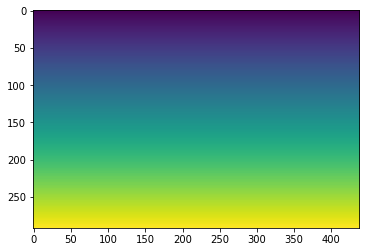

feature 2


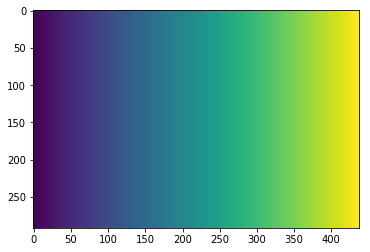

feature 3


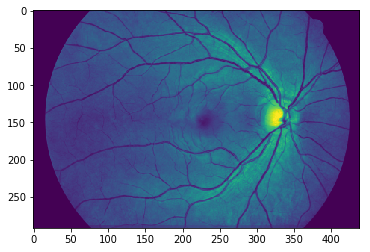

feature 4


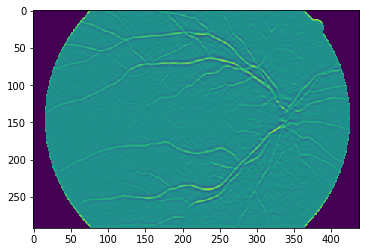

In [13]:
# Ruta preprocessed features
# X_train_val

h, w = 292, 438

# features_masked means outside the FOV the pixels have been set to 0
X_train_val = np.load("/content/gdrive/My Drive/Master_Thesis/features/features_masked.npy")

# it runs out here:
# RuntimeError: CUDA out of memory. Tried to allocate 528.00 MiB (GPU 0; 11.17 GiB total capacity; 7.83 GiB already allocated; 832.00 KiB free; 955.70 MiB cached)
X_train_val = torch.from_numpy(X_train_val).float().cuda()
#val_feats = val_feats.view(9, w*h, 30) #val_feats.view(9, w, h, 30)
X_train_val = X_train_val.view(36, 30, h, w)

#X_train_val = X_train_val.view(9, h, w, 30)
X_train_val = X_train_val.transpose(1, 3).transpose(1, 2)
print(X_train_val.shape)
print("dim", X_train_val.dim())

for i in range(4): #range(30):
  # x position
  # y position
  # g channel intensity
  # 27 other features
  print(f"feature {i+1}")
  plt.imshow(X_train_val[0,:,:,i].cpu())
  plt.show()

# validation -> split

In [14]:
# normalized between [0, 1], but we need them in range [-1, 1]
# actually it shouldn't matter?!?
for i in range(30):
  print(torch.min(X_train_val[0,:,:,i]).item(), torch.max(X_train_val[0,:,:,i]).item())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9667708277702332
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [15]:
# Ruta preprocessed features
# X_val

# masked means outside the FOV the pixels have been set to 0
npzfile = np.load("/content/gdrive/My Drive/Master_Thesis/features/test_features_masked.npz")
print(npzfile.files)
print(npzfile['features_masked'].shape)
X_val = npzfile['features_masked'] # numpy array
X_val = torch.from_numpy(X_val).float().cuda()
#X_val = X_val.view(9, w*h, 30) #X_val.view(9, w, h, 30)
X_val = X_val.view(9, 30, h, w)
print("X_val dtype", X_val.shape)
print("dim", X_val.dim())

#X_val = X_val.view(9, h, w, 30)
print(X_val.shape)
X_val = X_val.transpose(1, 3).transpose(1, 2)
print(X_val.shape)

['features_masked']
(9, 30, 127896)
X_val dtype torch.Size([9, 30, 292, 438])
dim 4
torch.Size([9, 30, 292, 438])
torch.Size([9, 292, 438, 30])


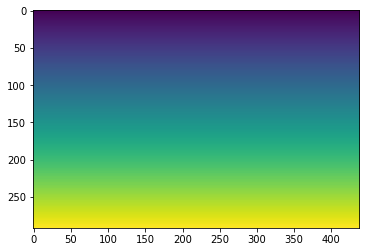

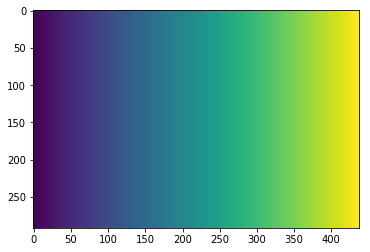

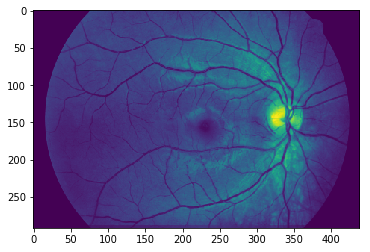

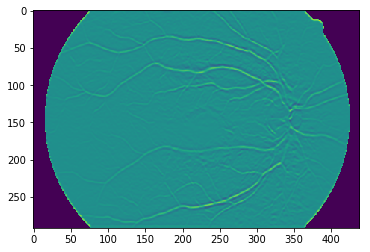

In [16]:
for i in range(4):#range(30):
  plt.imshow(X_val[0,:,:,i].cpu())
  plt.show()

In [17]:
for i in range(30):
  print(torch.min(X_train_val[0,:,:,i]).item(), torch.max(X_train_val[0,:,:,i]).item())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9667708277702332
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [18]:
for i in range(30):
  print(torch.min(X_val[0,:,:,i]).item(), torch.max(X_val[0,:,:,i]).item())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9999812841415405
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.993492841720581
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9695230722427368
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [19]:
for i in range(4):#range(30):
  print(X_val[0,:,:,i].shape)

torch.Size([292, 438])
torch.Size([292, 438])
torch.Size([292, 438])
torch.Size([292, 438])


In [20]:
npzfile = np.load("/content/gdrive/My Drive/Master_Thesis/features/train_same.npz")
for file in npzfile.files:
  print(file)
  print(npzfile[file].shape)
  
# segmentations_binary did not average the labels when resizing and but used a majority vote instead, retaining binary labels
# averaging interpolation pretains more information, thus we will use these

images
(36, 292, 438)
segmentations
(36, 292, 438)
masks
(36, 292, 438)
nx
()
ny
()
n
()
segmentations_binary
(36, 292, 438)


In [21]:
npzfile = np.load("/content/gdrive/My Drive/Master_Thesis/features/test_same.npz")
for file in npzfile.files:
  print(file)
  print(npzfile[file].shape)

images
(9, 292, 438)
segmentations
(9, 292, 438)
masks
(9, 292, 438)
nx
()
ny
()
n
()
segmentations_binary
(9, 292, 438)


In [22]:
npzfile = np.load("/content/gdrive/My Drive/Master_Thesis/features/train_same.npz")  # 'train_same' means train
y_train_val = npzfile['segmentations']  # segmentations means these are the ground truth labelings, i.e. y
mask_train_val = npzfile['masks']
print(type(y_train_val))
print(type(mask_train_val))

#y_train_bin = npzfile['segmentations_binary']
#plt.imshow(y_train[0])
#plt.show()
#plt.imshow(y_train_bin[0])
#plt.show()

npzfile = np.load("/content/gdrive/My Drive/Master_Thesis/features/test_same.npz")
y_test = npzfile['segmentations']
mask_test = npzfile['masks']
print(type(y_train_val))
print(type(mask_test))


y_train_val = toTensor(y_train_val)
y_test = toTensor(y_test)
mask_train_val = toTensor(mask_train_val)
mask_test = toTensor(mask_test)
print(type(y_train_val))
print(type(y_test))
print('train labels shape: ', y_train_val.shape)
print('test labels shape: ', y_test.shape)
y_train_val = y_train_val.transpose(0, 1).transpose(1, 2)
y_test = y_test.transpose(0, 1).transpose(1, 2)
mask_train_val = mask_train_val.transpose(0, 1).transpose(1, 2)
mask_test = mask_test.transpose(0, 1).transpose(1, 2)
y_train_val = y_train_val.to(dtype=torch.float32).cuda()
y_test = y_test.to(dtype=torch.float32).cuda()
mask_train_val = mask_train_val.to(dtype=torch.float32).cuda()
mask_test = mask_test.to(dtype=torch.float32).cuda()
print('train labels dtype: ', y_train_val.dtype)
print('test labels dtype: ', y_test.dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train labels shape:  torch.Size([438, 36, 292])
test labels shape:  torch.Size([438, 9, 292])
train labels dtype:  torch.float32
test labels dtype:  torch.float32


In [23]:
# Ruta split
torch.manual_seed(2809)
np.random.seed(2809)

n = len(X_train_val) #[:3])
val_n = int(n/3)
print(f"n: {n}\nval_n: {val_n}")  # n = 36 -> train_n = 24 and val_n = 12 
batchIndices = np.arange(n)

shuffle = True

if(shuffle):
  batchIndices = np.random.permutation(batchIndices) # Shuffle frames 
print(f"batchIndices: {batchIndices}")

trainIdx = batchIndices[ val_n: ] # skip the val_N first entries for training set
valIdx = batchIndices[ :val_n ] # take the val_n fisrt entries for validation set
print(f"trainIdx: {trainIdx}")
print(f"valIdx: {valIdx}")

# can't cast list to tensor: ValueError: only one element tensors can be converted to Python scalars
# instead look at dmadeka1 in https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868
#X_val = torch.FloatTensor([X_train_val[i] for i in valIdx])
#
#y_train = torch.FloatTensor([y_train_val[i] for i in trainIdx])
#y_val = torch.FloatTensor([y_train_val[i] for i in valIdx])

  
X_train = torch.stack([X_train_val[i] for i in trainIdx])  # or use toTensor(...) ?
X_val = torch.stack([X_train_val[i] for i in valIdx])

y_train = torch.stack([y_train_val[i] for i in trainIdx])
y_val = torch.stack([y_train_val[i] for i in valIdx])

mask_train = torch.stack([mask_train_val[i] for i in trainIdx])
mask_val = torch.stack([mask_train_val[i] for i in valIdx])

n: 36
val_n: 12
batchIndices: [11 19 35 21 31  5 15 22 34  7 23 10 13  3 17 33  0 24 14 27 26 29 20  4
 28  2  1 32 12  8  9  6 30 16 18 25]
trainIdx: [13  3 17 33  0 24 14 27 26 29 20  4 28  2  1 32 12  8  9  6 30 16 18 25]
valIdx: [11 19 35 21 31  5 15 22 34  7 23 10]


In [0]:
# normalized between [0, 1], but we need them in range [-1, 1]
# actually it shouldn't matter?!?
X_train = normalize(X_train)
X_val = normalize(X_val)

In [25]:
_, h, w, F = X_train.shape
N = h*w

print(f"h, w, F: {h}, {w}, {F}")
print(f"N: {N}")

print('train images shape: ', X_train.shape)
print('train labels shape: ', y_train.shape)
print('train masks shape: ', mask_train.shape)
print('valid images shape: ', X_val.shape)
print('valid labels shape: ', y_val.shape)
print('valid masks shape: ', mask_val.shape)

print('train images dtype: ', X_train.dtype)
print('train labels dtype: ', y_train.dtype)
print('train masks dtype: ', mask_train.dtype)
print('valid images dtype: ', X_val.dtype)
print('valid labels dtype: ', y_val.dtype)
print('valid masks dtype: ', mask_val.dtype)

print('train images is_cuda: ', X_train.is_cuda)
print('train labels is_cuda: ', y_train.is_cuda)
print('train masks is_cuda: ', mask_train.is_cuda)
print('valid images is_cuda: ', X_val.is_cuda)
print('valid labels is_cuda: ', y_val.is_cuda)
print('valid masks is_cuda: ', mask_val.is_cuda)

h, w, F: 292, 438, 30
N: 127896
train images shape:  torch.Size([24, 292, 438, 30])
train labels shape:  torch.Size([24, 292, 438])
train masks shape:  torch.Size([24, 292, 438])
valid images shape:  torch.Size([12, 292, 438, 30])
valid labels shape:  torch.Size([12, 292, 438])
valid masks shape:  torch.Size([12, 292, 438])
train images dtype:  torch.float32
train labels dtype:  torch.float32
train masks dtype:  torch.float32
valid images dtype:  torch.float32
valid labels dtype:  torch.float32
valid masks dtype:  torch.float32
train images is_cuda:  True
train labels is_cuda:  True
train masks is_cuda:  True
valid images is_cuda:  True
valid labels is_cuda:  True
valid masks is_cuda:  True


In [26]:
# put this into every cell that makes random choices
torch.manual_seed(42)
print(torch.randn(1))
if torch.cuda.is_available():
  print("GPU is available.")
  torch.cuda.manual_seed_all(42)
  
def threshold(tensor, T):
  index_tensor = tensor > T
  binary_tensor = torch.zeros(index_tensor.shape)
  binary_tensor[index_tensor] = 1
  return binary_tensor

#a = torch.randn((5,5))
#thresholding(a, 0.5)

tensor([0.3367])
GPU is available.


In [0]:
# source: user Danijel at https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python
class Timer:
  def __init__(self):
    self.start = time.time()

  def restart(self):
    self.start = time.time()

  def get_time_hhmmss(self):
    end = time.time()
    m, s = divmod(end - self.start, 60)
    h, m = divmod(m, 60)
    time_str = "%02dh%02dm%02ds" % (h, m, s)
    return time_str

In [0]:
# source: https://github.com/pytorch/pytorch/issues/1249
def dice_loss(y_pred, y_true):
  """
  dice score(A, B) = 2 * |intersection(A, B)| / |A| + |B|
  dice loss = 1-dice_score
  """
  #raise Exception(f"{y_pred.unique()}, {y_true.unique()}")
  smooth = 1.
  pflat = y_pred.view(-1)
  tflat = y_true.view(-1)
  #print(pflat.dtype) # float32
  #print(tflat.dtype) # float32
  # since both "y" tensors are 0,1-binary, their element-wise product will tell us where both are 1 -> intersection
  intersection = (pflat * tflat).sum()
  
  # smooth prevents dividing by 0 and ??
  # the set size of A is the number of elements in A which corresonds to the number of 1's in A -> sum
  return 1 - ((2. * intersection + smooth) /
            (pflat.sum() + tflat.sum() + smooth))

In [0]:
import numpy as np
import torch

def mk_sparse_adj(h, w):
  """
  Constructs a binary adjacency matrix for an image of dimnesions h, w.
  Each pixel is connected to 8 surrounding pixels and itself, 
  except for the pixels at the border, which have no outgoing connections 
  (only incoming ones).
  """
  N = h*w
  image = np.arange(N)
  x = np.array([])
  for i in range(1, h-1):
    #print( np.arange(i*w+1, ((i+1)*w)-1) )
    x = np.concatenate((x, np.arange(i*w+1, ((i+1)*w)-1 )))
  
  # y is 9 times as long as x
  # len(x) = number of found pixels with neighbours
  # +4 because 3 more but range is exclusive 
  win_slice = np.array([-1, 0, 1])
  win = np.concatenate((win_slice-w, win_slice, win_slice+w)) # len = 9
  #y = np.repeat(x, 9) + np.tile(np.concatenate(  ( np.arange(-w-1, -w-1+4), np.arange(-1, -1+4), np.arange(w-1, w-1+4))  ), len(x))
  y = np.repeat(x, 9) + np.tile(win, len(x))
  # get x to same length as y
  x = np.repeat(x, 9)

  #print("x", x)
  #print("y", y)
  
  i = torch.tensor([x, y]).long()  # else it will autocast to double, whereas v is autocast to long and it gives a type error in sparse.FloatTensor
  v = torch.ones(x.shape)
  
  adj = torch.sparse.IntTensor(i, v, torch.Size([N, N])).cuda()
  
  return adj

In [0]:
def sparse_vectorized_cos_sim(adj, feats, eps=1e-6):
  """
  Method used for preprocessing of cosine similarity matrix. (see ~2 cells below)
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  feats: (N, F) dense feature tensor
  returns: (N, N) sparse tensor containing cosine similarities
  """
  N = adj.shape[0]
  nE = adj._nnz()  # number of non-zero elements = number of edges
  eIdx = torch.cuda.LongTensor(np.arange(nE)) # 0 1 2 3 4 5 6 7 8
  vals = torch.cuda.FloatTensor(np.ones(nE))
  
  # Source node transformer
  nIdx = adj._indices()[0, :]
  #print(f"eIdx is cuda? {eIdx.is_cuda}")
  #print(f"nIdx is cuda? {nIdx.is_cuda}")
  indices = torch.stack((eIdx, nIdx))
  n2e_in = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N]))
  
  # Sink node transformer
  nIdx = adj._indices()[1, :]
  indices = torch.stack((eIdx, nIdx)) # returns tensor([eIdx, nIdx])
  n2e_out = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N]))
  
  # Obtain features of source nodes
  #print(f"n2e_in is cuda? {n2e_in.is_cuda}")
  #print(f"feats is cuda? {feats.is_cuda}")
  x_in = torch.mm(n2e_in, feats)
  # Obtain features of sink nodes
  x_out = torch.mm(n2e_out, feats)
  
  # Cosine similarity
  num = (x_in * x_out).sum(1) + eps # A * B, where A = incoming features, B = outgoing features
  denom = torch.norm(x_in, dim=1) * torch.norm(x_out, dim=1) + eps # norm(A) * norm(B)
  cosSimValues = num/denom  # values tensor for sparse tensor
  if torch.isnan(cosSimValues).any():
    raise Exception(f"num: {num}\ndenom: {denom}")
  cosSim = torch.cuda.sparse.FloatTensor(adj._indices(), cosSimValues, torch.Size([N, N]))
  return cosSim

def get_n2e_in_out(adj):
  """
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  returns: n2e_in - (nE, N) sparse tensor indicating the ingoing 
          edges of adj from edge notation to node notation, called sink node transformers
          n2e_out - (nE, N) sparse tensors indicating the outgoing edges of adj 
          from edge notation to node notation, called source node transformers
  """
  
  N = adj.shape[0]
  nE = adj._nnz()  # number of non-zero elements = number of edges
  eIdx = torch.cuda.LongTensor(np.arange(nE)) # 0 1 2 3 4 5 6 7 8
  vals = torch.cuda.FloatTensor(np.ones(nE))
  
  # Source node transformer
  nIdx = adj._indices()[0, :] # get x-pos of indices
  indices = torch.stack((eIdx, nIdx))
  n2e_in = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N]))
  
  # Sink node transformer
  nIdx = adj._indices()[1, :] # get y-pos of indices
  indices = torch.stack((eIdx, nIdx)) # returns tensor([eIdx, nIdx])
  n2e_out = torch.cuda.sparse.FloatTensor(indices, vals, torch.Size([nE, N]))
  
  return n2e_in, n2e_out

def sparse_vectorized_probs(adj, n2e_in, n2e_out, probs):
  """
  adj: (N, N) sparse tensor in binary format, indicating node connections with 1s
  n2e_in - (nE, N) sparse tensor indicating the ingoing 
          edges of adj from edge notation to node notation, called sink node transformer
  n2e_out - (nE, N) sparse tensor indicating the outgoing edges of adj 
          from edge notation to node notation, called source node transformer
  probs: (N, 1) dense probability tensor q_i
  returns: (N, N) sparse tensor constaining all combinations (q_i * q_j)
                  at positions indicated by adj
  """
  sparse_vectorized_probs_timer = Timer()
  # Obtain probs of source nodes
  x_in = torch.mm(n2e_in, probs)
  # Obtain probs of sink nodes
  x_out = torch.mm(n2e_out, probs)
  
  # calculate all pairwise products q_i * q_j that are of interest
  prob_prod_values = (x_in * x_out).sum(1)
  prob_products = torch.cuda.sparse.FloatTensor(adj._indices(), prob_prod_values, torch.Size([N, N]))  # qi * qj
  
  x_in2 = torch.mm(n2e_in, 1-probs)  # qi
  x_out2 = torch.mm(n2e_out, 1-probs)  # (1-qi)
  
  prob_products2 = torch.cuda.sparse.FloatTensor(adj._indices(), (x_in * x_out2).sum(1), torch.Size([N, N]))  # qi * (1-qj)
  prob_products3 = torch.cuda.sparse.FloatTensor(adj._indices(), (x_in2 * x_out).sum(1), torch.Size([N, N]))  # (1-qi) * qj
  prob_products4 = torch.cuda.sparse.FloatTensor(adj._indices(), (x_in2 * x_out2).sum(1), torch.Size([N, N]))  # (1-qi) * (1-qj)
  
  #print(f"sparse_vectorized_probs time: {sparse_vectorized_probs_timer.get_time_hhmmss()}") ## always 0s
  return prob_products, prob_products2, prob_products3, prob_products4


In [44]:
# torch's cosine similarity for a given pair of tensors
import torch
cos_sim = torch.nn.CosineSimilarity(dim=0, eps=1e-8)
cos_sim(torch.FloatTensor([3, 0]), torch.FloatTensor([1, 1]))

tensor(0.7071, device='cpu')

In [45]:
# have adjacency matrix/indicator_mat and cos sim be part of preprocessing because it might be slow
# consider saving cos_sim for each input image as pickle
timer = Timer()

print(f"h, w: {h}, {w}")
print(f"F: {F}") # defined based on data X_train.shape, not saved in model!
adj_mat = mk_sparse_adj(h, w).cuda()
E = adj_mat._nnz()
print(f"E: {E}")
print("adj_mat\n", adj_mat)

sims_train = []
for image in X_train:
  # image.shape = (h, w, F)
  cosSim = sparse_vectorized_cos_sim(adj_mat, image.view(N, F))
  sims_train.append(cosSim)
print(f"Constructed one similarity matrix for each of {len(sims_train)} train images.")

sims_val = []
for image in X_val:
  # image.shape = (h, w, F)
  cosSim = sparse_vectorized_cos_sim(adj_mat, image.view(N, F))
  sims_val.append(cosSim)

print(f"Constructed one similarity matrix for each of {len(sims_val)} val images.")

## calculate cos sim. of all pairs of feature vectors
#for i in indicator_mat._indices()[0]:  # x values of indices
#  for j in indicator_mat._indices()[1]: # y values of indices
#    pxl_i = feats_flat[i]
#    pxl_j = feats_flat[j]
#    # (N) = cos_sim_dim1[(N, F) x (N, F)]
#    #print(f"pxl_i.shape: {pxl_i.shape}")
#    #print(f"features:\n{pxl_i}\n{pxl_j}")
#    
#    v_pw_cos_sim = self.cos_sim(pxl_i, pxl_j)  # .item()?
#    if (torch.isnan(v_pw_cos_sim)):
#      print("found nan in pw_cos_sim")
#      print(f"pixel i and j: ({i}, {j})")
#      print(f"features:\n{pxl_i}\n{pxl_j}")
#      
#print(f"nnz in indicator_mat:{indicator_mat._nnz()}")
#
print("sims_train[0]\n", sims_train[0])
print("sims_train[0] unique values:\n", torch.unique(sims_train[0]._values()))

n2e_in, n2e_out = get_n2e_in_out(adj_mat)

print(f"time:\n{timer.get_time_hhmmss()}")

h, w: 292, 438
F: 30
E: 1137960
adj_mat
 tensor(indices=tensor([[   439,    439,    439,  ..., 127456, 127456, 127456],
                       [     0,      1,      2,  ..., 127893, 127894, 127895]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(127896, 127896), nnz=1137960, layout=torch.sparse_coo)
Constructed one similarity matrix for each of 24 train images.
Constructed one similarity matrix for each of 12 val images.
sims_train[0]
 tensor(indices=tensor([[   439,    439,    439,  ..., 127456, 127456, 127456],
                       [     0,      1,      2,  ..., 127893, 127894, 127895]]),
       values=tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]),
       size=(127896, 127896), nnz=1137960, layout=torch.sparse_coo)
sims_train[0] unique values:
 tensor([-0.9529, -0.9498, -0.9409,  ...,  1.0000,  1.0000,  1.0000])
time:
00h00m18s


In [46]:
import torch
import numpy as np

torch.manual_seed(1337)

def logit(p, eps = 1e-6):
  """ tensor version
  logit(p) = log(p/(1-p)) = log(1/p -1)"""
  
  p_eps = p#+eps
  p_eps[p_eps == 0] = eps
  p_eps[p_eps == 1] = 1-eps
  arg = p_eps/(1 - p_eps)
  if torch.isnan(torch.log(arg)).any():
    print(f"logit of this vector contains a NaN!!!!\ntorch.log(arg)={torch.log(arg)}\narg={arg}\nNumerator={p_eps}\nDenominator={1 - p_eps}")
  return torch.log(arg)


# get 5 values uniformely distributed (torch.rand) between r1 and r2
r1, r2 = 0, 1
p = torch.cuda.FloatTensor(5,5).uniform_(r1, r2)
p = torch.cuda.FloatTensor(np.arange(0, 1.1, 0.1))
p = torch.arange(0, 1.1, 0.1)
print(p)
logit(p) # apparently, log(1e-6) = -13.8155 and log(1-1e-6) = 13.8023
#
#import numpy as np
#eps = 1e-6
#p = np.arange(0,1,0.1) + eps
#
#print(np.log(p/(1-p)))

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])


tensor([-13.8155,  -2.1972,  -1.3863,  -0.8473,  -0.4055,   0.0000,   0.4055,
          0.8473,   1.3863,   2.1972,  13.8023])

In [0]:
def debug_memory():
  """
  https://forum.pyro.ai/t/a-clever-trick-to-debug-tensor-memory/556
  Call this function at any point in time (e.g. during training), 
  to see the location (cpu/gpu), shape and number of tensors of same 
  loc&shape in memory.
  """
  import collections, gc, resource, torch
  print('maxrss = {}'.format(
      resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
  tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                for o in gc.get_objects()
                                if torch.is_tensor(o))
  for line in sorted(tensors.items()):
      print('{}\t{}'.format(*line))

In [0]:
## Model analysis
## attention, cell has to be under Model in order to work

#mfn = MFN(h, w, iterations=1)
#print(mfn)
#
#
## Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in mfn.state_dict():
#    print(param_tensor, "  \t", mfn.state_dict()[param_tensor].shape)
#
### Print optimizer's state_dict
##print("Optimizer's state_dict:")
##for var_name in optimizer.state_dict():
##    print(var_name, "\t", optimizer.state_dict()[var_name])

In [0]:
import torch.nn as nn
import torch.nn.functional as Fun  # usually imported as F but that variable is already the number of features


torch.autograd.Variable
torch.set_default_tensor_type('torch.cuda.FloatTensor')

class MFN(nn.Module):
    def __init__(self, h, w, iterations=5):
        """Initialize the MFN model

        Args:
            h: int, height of image
            w: int, width of image
            iterations: int, number of mean field iterations, e.g. 10
            
        Model should be cuda/cpu agnostic? see:
            https://discuss.pytorch.org/t/how-can-i-know-if-a-variable-is-a-cuda-varialbe/8460/2
        """
        super(MFN, self).__init__()
        self.fc_layer1 = nn.Linear(in_features=F, out_features=32, bias=True)
        self.fc_layer2 = nn.Linear(in_features=32, out_features=32, bias=True)
        #nn.functional.sigmoid() same (deprecated even?) as: torch.sigmoid()
        self.out_layer = nn.Linear(32, 1, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.logit = logit #nn.Logit() #doesn't exist
        
        # define variables here that don't change for a model instance, so you 
        # they don't have to be redefined during each forward call (i.e. during 
        # each backprop)
        self.h = h
        self.w = w
        self.N = self.h * self.w  # number of nodes/pixels within the fully CRF
        self.bN = self.N - 2*self.h - 2*self.w + 4  # borderless N
        self.iterations = iterations
        self.graphs = []

        # work in edge space, shape (E)
        self.W = nn.Parameter(torch.ones(E), requires_grad=True)
        # requires_grad is contagious. It means that when a Tensor is created by operating on other Tensors, the requires_grad of the resultant Tensor would be set True given at least one of the tensors used for creation has it's requires_grad set to True.


        
    def forward(self, feats, sim):  # variable image is really variable feats
      """
      feats: (h, w, F) feature tensor, Features of a single image are passed 
              through the network. In pytorch, the network architecture is 
              agnostic to all but the last dimension (F)
              
      sim:   (N, N) sparse similarity tensor
      
      return: prob_map (h, w, 1) tensors of vessel probabilities
      """
      
      ### MLP
      timer_forward = Timer()
      #print("started forward pass")
      
      x = feats.clone()
      x = self.relu(self.fc_layer1(x))
      x = self.relu(self.fc_layer2(x))
      # apply sigmoid to return probability map
      x = self.out_layer(x)  # shape (h, w, 1)
      # watch out! prob_map is shape (h, w, 1), not (h, w), which makes for a 
      # lot of hassle, but pytorch's NN are built in a way where the feature 
      # dimension (3rd dim) of input will result in an output dimension, thereby giving the output same number of dimensions as input
      mlp_prob_map = self.sigmoid(x)  # shape (h, w, 1)
      
      if debug:
        print(f"prob_map after MLP:")  # printing for every MFiteration might get a little too much
        prob_map_detached = mlp_prob_map.clone().cpu().detach()[:,:,0]  # tensor access removes third dimension (which is empty, but needed for model), thereby making it 2d for imshow
        plt.imshow(prob_map_detached)
        plt.show()
      
      #print("########################\nprob_map", prob_map)  # gradient <Sigmoid>
      #prob_map = prob_map.squeeze(2)  # shape (h, w)  # overwriting a variable inplace with squeeze will give error when backpropagating
      #prob_map = prob_map.view(self.h, self.w)
      #print(f"prob_map.shape: {prob_map.shape}") # shape (h, w, 1)
      # remove border, b -> borderless, reason: adj_mat which indicates for borderpixels that they have less than 9 neigbours results in adj_mat rows with less than 9 1s, thus reshaping them with view(-1, 9) gives unexpected results
      mlp_prob_map_b = mlp_prob_map[1:h-1, 1:w-1, :] # (h, w, 1) -> (h-2, w-2, 1) 
      #print(f"prob_map_b.shape: {prob_map_b.shape}") # shape (h-2, w-2, 1)
           
      # mlp_prob_flat = Q_0
      mlp_prob_flat = mlp_prob_map.view(self.N)  # shape (N)
      mlp_prob_flat_b = mlp_prob_map_b.contiguous().view(self.bN)  # shape (bN)
      
      un_pot_flat = self.logit(mlp_prob_flat_b)  # bN <- bN

      mfn_prob_flat = mlp_prob_flat  # for the first MFiteration, Qi = Q0 for the pairwise potential (note: unary potentail always uses Q0, i.e. mlp_probs_flat)
      
      mean_pseudo_ELBOs = []
      ### MFI, mean field iterations, CRF needs feats and preds
      timer_mfi = Timer()
      for mf_it in range(self.iterations):
        #print(f"MFI {mf_it+1}")
        pw_cos_sim = sim # sparse (N, N)
        pw_pot = self.W * pw_cos_sim._values()  # (E) = (E) * (E) (all sparse, elementwise_multiplication, make sure nnz is same before and after multiplication!)
        
        ## message passing:
        # calculate all relevant products q_i * q_j
        # Right now, only interested in the case y_i = y_j = 1 (both pixels have
        # prediction "vessel"),
        # meaning we only need to multiply with qiqj
        # sparse (N, N) , dense (N, 1) -> sparse (N, N) with values probs_flat*probs_flat_T at positions of adj_mat
        
        # adj_mat: indicates adjacent pixels, n2e_in/out: indicates incoming/outgoing pixels in n2e format
        timer1 = Timer()
        qi_qj, qi_omqj, omqi_qj, omqi_omqj = sparse_vectorized_probs(adj_mat, n2e_in, n2e_out, mfn_prob_flat.view(self.N, -1))  # sparse (N, N) <- sparse (N,N) * (N, 1) 
        print(f"timer1: {timer1.get_time_hhmmss()}")
        if debug:
          print(f"Unique qi * qj for all edges (i,j):\n{qiqj._values().unique()}")
        
        # training can happen in edge space
        # Take expectation of pw potential
        exp_pw_pot_values = (qi_qj._values() + omqi_omqj._values()  # prob of labels that agree
                             - qi_omqj._values() - omqi_qj._values()  # prob of labels that disagree
                            )* pw_pot         # (E) <- (E) * (E)
        # need to move to node space in order to sum over the correct rows
        # (E, N) and (N, 1)
        timer2 = Timer()
        exp_pw_pot = torch.cuda.sparse.FloatTensor(adj_mat._indices(), exp_pw_pot_values, adj_mat.shape)  #torch.Size([self.N, self.N]))
        print(f"timer2: {timer2.get_time_hhmmss()}")
        pw_pot_flat = exp_pw_pot._values().view(-1, 9).sum(dim=1)  # (bN) <- (bN, 9) <- (E) ##view: (N, N) -> (N*2, 9) ????
        
        # un_pot_flat is given by MLP and stays the same throughout MF iterations
        E_flat = un_pot_flat + pw_pot_flat  # bN <- bN + bN
        
        # imlpemented sigmoid function/ softmax  manually, over all the pixels
        # Z = tvorch.sum(torch.exp(E_flat))  # it E is in non-log space, dividing by sum #will normalize it
        #prob_map_flat = torch.exp(E_flat)/Z
        
        # since MFN assume that prob Q is factorizable into Qis, it automatically
        # also assumes that partition function is factorizable. To go from energy to prob space we need to apply sigmoid s(x) = exp(x)/exp(x)+1 = 1/exp(x)+1
        # The normalization step 1/Z is factorizable in MFN model, thus every Energy is normalized via individual Z_i, corresponding to sigmoid function
        # mfn_probs = Q_i
        mfn_prob_flat_b = self.sigmoid(E_flat) # bN <- bN
        
        mfn_prob_map_b = mfn_prob_flat_b.view(self.h-2, self.w-2)  # (h-2, w-2, 1) <- (bN)
                
        # (x, y, a, b) pads last dimension by x in front, y in back and second to last by a in front, b in back
        p2d = (1, 1, 1, 1)
        # set border to 0s (border is always mask, therefore it's label always background)
        prob_map = Fun.pad(mfn_prob_map_b, pad=p2d, value=0)  # (h, w)
        
        mfn_prob_flat = prob_map.view(self.N)  # shape (N)

        if debug:
          print(f"prob_map iteration {mf_it+1}:")  # printing for every MFiteration might get a little too much
          prob_map_detached = prob_map.clone().cpu().detach()#[:,:,0] # tensor access removes third dimension (which is empty, but needed for model), thereby making it 2d for imshow
          plt.imshow(prob_map_detached)
          plt.show()
        
        prob_map = prob_map.unsqueeze(2)  # why doesn't this throw an error when backpropagating? I'm changing the variable in place?
      print(f"timer_mfi: {timer_mfi.get_time_hhmmss()}")
      if self.iterations == 0:
        return mlp_prob_map
      else:
        return mlp_prob_map, prob_map 
#        # ELBO = E_q [E(X,Y)/Z + log(Z)] - E_q[log(Q(Y))] (the second term is the shannon entropy)
#        # pseudo_ELBO = E_q [E(X,Y)/Z ] - E_q[log(Q(Y))] (easier to compute)
#        with torch.no_grad():
#          ## un_pot_flat = self.logit(mlp_probs_flat_b), you cannot recalculate that values because it will make backtracking impossible
#          ## self.logit(1-mlp_probs_flat_b) on the other hand, hasn't been calculated yet
#          exp_unary_pot = mlp_probs_flat_b * un_pot_flat + (1-mlp_probs_flat_b) * self.logit(1-mlp_probs_flat_b)
#           #exp_unary_pot = mlp_probs_flat_b * un_pot_flat + (1-mlp_probs_flat_b) * un_pot_flat
#          
#          exp_PXY = exp_unary_pot + pw_pot_flat # bN = bN + bN , expectation w/ respect to Q of P[X,Y]
#          H = -1*(mfn_prob_flat_b * torch.log(mfn_prob_flat_b) + (1-mfn_prob_flat_b) * torch.log(1-mfn_prob_flat_b) )  # H[Y] = shannon entropy
#          pseudo_ELBO = exp_PXY + H  # N ELBOs where N = number of pixels
#          mean_pseudo_ELBO = torch.mean(pseudo_ELBO)
#          print(f"mean pseudo ELBO: {mean_pseudo_ELBO}")
#          mean_pseudo_ELBOs.append(mean_pseudo_ELBO)
#      
#      self.graphs.append(mean_pseudo_ELBOs)
#      
#      if debug:
#        if len(self.graphs) <= 10:
#          for i, graph in enumerate(self.graphs):
#            plt.plot(np.arange(1, self.iterations+1), graph, label=f"epoch {i+1}")
#            plt.legend()
#          plt.show()
#        else:
#          stepsize = int(len(graphs)/10)
#          for i, graph in enumerate(self.graphs[::stepsize]):
#            plt.plot(np.arange(1, self.iterations+1), graph, label=f"epoch {i+1}")
#            plt.legend()
#          plt.show()        
      #print(f"prob_map.shape: {prob_map.shape}")


In [70]:
### hyperparameters ###########################################
debug = False

# path to save the model under
epochs = 2  # 1000s of epochs needed later
# reload the model so it is reinitialized
# google colab has 12.7 GB RAM, which means h*w can't be bigger than ...?
model = MFN(h=h, w=w, iterations=5)

print(f"epochs: {epochs}")
print(f"MF iterations: {model.iterations}")
print(f"h, w, F: {model.h}, {model.w}, {F}")
print(f"N: {model.N}")
# borderless N
print(f"bN: {model.bN}")
E = adj_mat._nnz()
print(f"E: {E}")

if torch.cuda.is_available():
  model.cuda()
  print("Running model on GPU.")
#mlp = MLP()
lr = 1e-2
num_saves = 200
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(f"learning rate: {lr}")#{optimizer.lr}")
# only save every <save_step>th output out of all <epochs> outputs:
print(f"number of saves: {num_saves}")
# You should pass logits to nn.BCEwithLogitsLoss and probabilities (received by using sigmoid) to nn.BCELoss.
#loss_fn = nn.BCELoss() # don't use BCEwithLogitsLoss when you are already applying the sigmoid in the model!
loss_fn = dice_loss  # type = <class function>
###############################################################
print(f"X_train.shape: {X_train.shape}")
print(f"Number of training images: {X_train.shape[0]}")
print(f"Number of validation images: {X_val.shape[0]}")

epochs: 2
MF iterations: 5
h, w, F: 292, 438, 30
N: 127896
bN: 126440
E: 1137960
Running model on GPU.
learning rate: 0.01
number of saves: 200
X_train.shape: torch.Size([24, 292, 438, 30])
Number of training images: 24
Number of validation images: 12


In [73]:
# rerunning this cell will use the pretrained model of the cell above, but the losses and predictions are all reset

import torch.nn.functional as Fun  # usually imported as F but that variable is already the number of features
from tqdm import tqdm

# put this into every cell that makes random choices
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  print("GPU is available.")
  torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

# for debugging purposes (Hint of error message where "variables needed for gradient computation has been modified by an inplace operation")
torch.autograd.set_detect_anomaly(True) # will throw RuntimeError: Function 'DivBackward0' returned nan values in its 0th output. after about 333 epochs


# save the mean losses of all forward-backward passes of one epoch, such as to plot them later
mean_train_losses = []
mean_valid_losses = []
mean_mlp_train_losses = []
mean_mlp_valid_losses = []
valid_acc_list = []
outputs_train = []  # predictions
outputs_val = []
#model.zero_grad()  #not needed, since reinitializing the model in the line above already zeros the grads

#X_train = 2*(X_train - X_train.min(2))
timer = Timer()
# one epoch is as many forward + backward passes until all training data was passed once
#for epoch in tqdm(range(epochs)):
for epoch in np.arange(1, epochs+1): ## range [1, 2001]
  epoch_timer = Timer()
  
  # declare the mlp to train now?
  model.train()
  
  # save losses after every batch of dataset that is read, i.e. after each forward-backward pass
  train_losses = []
  valid_losses = []
  mlp_train_losses = []
  mlp_valid_losses = []
    
  # pass the training data
  # if using DataLoader instead (imported function, not self-written one!) and batchsize > 1, then var "image" will contain several images
  # training with just one image per epoch will be good enough to debug and test all hyperparameters and run a lot quicker
  for i, (image, labels, mask, sim) in list(enumerate(zip(X_train, y_train, mask_train, sims_train))):
    if debug:
      plt.imshow(labels.detach().cpu().numpy())
      plt.show()
    # image = features in image form (h, w, f), labels = ??, sim = sparse similarities (N, N)
    #outputs = torch.zeros(h, w)  # this line seems unecessary
        
    mask = mask.type(torch.cuda.ByteTensor)  # cast to boolean tensor in order to make indexing possible [addendum: actually casts from default (float) to dtype=torch.uint8)]
    #print(f"mask.is_cuda(): {mask.is_cuda}")

    # Every time a variable is backpropagated through, the gradient will be accumulated instead of being replaced. (This makes it easier for rnn, because each module will be back propogated through several times.)
    # To prevent this, we manually zero the gradients after each batch
    optimizer.zero_grad()  # maybe this line should stand above loss=loss_fn(...) lin
    # runs forward pass on the data point from training set
    
    mlp_outputs, outputs = model(image, sim)  # applying the mask before predicting could about half the size of the feature vectors, but because of optimized vector multiplications, this doesn't make that big a difference
    #print(f"outputs.is_cuda(): {outputs.is_cuda}")

    #plt.plot(mean_pseudo_ELBOs, label=f"epoch {epoch}")
    
    # outputs shape is (h, w, 1) because last layer's n_output = 1
    # outputs = outputs.squeeze(2)
  
    # outputs[mask] returns a 1D tensor with all the pixel values of outputs
    # that are inside the mask, from now on it will no longer be visualizable,
    # as a reshape will "square" it instead of "ellipsing" it

    #print("outputs.shape", outputs.shape) # (h, w, 3)
    #print("labels.shape", labels.shape) # (h, w)
    #print("mask.shape", mask.shape)  # (h, w)
    
    mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])
    loss = loss_fn(outputs[mask], labels[mask])
    
    #print(outputs.unique()) # lots of nan in there (in python, no 2 nan are equal)
    if debug:
      print(f"train_loss = {loss}")
    
    # backwards propagation / autograd
    #pdb.set_trace()
    loss.backward()
    optimizer.step()
  
    # after each image read-in, the loss is saved
    mlp_train_losses.append(mlp_loss.item())
    train_losses.append(loss.item())

    # save the training outputs for debugging
    # only save every 10th output
    if i == 0: # only save outputs for 1 training image, so that we can easily follow the progress
      outputs_train.append(outputs)
      #if epochs <= 10:  # avoid ZeroDivisionError: integer division or modulo by zero
      #  outputs_train.append(outputs)
      ## 0 % 2000//10 = 0 % 200 = 0 -> not 0 = True
      ## 200 % 2000//10 = 200 % 200 = 0 -> not 0 = True
      #elif not epoch-1 % (epochs-1//num_saves): 
      #  outputs_train.append(outputs)
  # Tell the mlp that we're evaluating now
  # model.eval() will notify all our layers that you are in eval mode,
  # that way, batchnorm or dropout layers will work in eval mode instead of 
  # training mode.
  model.eval()
  # to manually calculate accuracy, we need # of correct and total #
  correct = 0
  total = 0
  # no backpropagation needed in this part, this speeds up computation
  with torch.no_grad():
    # runs forward pass on the data point from validation set      
    for i, (image, labels, mask, sim) in list(enumerate(zip(X_val, y_val, mask_val, sims_val))):
      # test on 4 val images so that there is a little more variation, 
      # especially relevant since images in HRF can be flipped along middle 
      # vertical axis
      outputs = torch.zeros(h, w)
      mask = mask.type(torch.ByteTensor)  # cast to boolean tensor in order to make indexing possible [addendum: actually casts from default (float) to dtype=torch.uint8)]

      # Every time a variable is back-propogated through, the gradient will be accumulated instead of being replaced. (This makes it easier for rnn, because each module will be back propogated through several times.)
      # To prevent this, we manually zero the gradients after each batch
      optimizer.zero_grad()

      # runs forward pass on the data point from training set
      mlp_outputs, outputs = model(image, sim)  # right now not intersted in ELBOS of validation
          
      #print(f"outputs for image number {i}")
      #plt.imshow(outputs.detach().cpu().numpy()[:,:,0])  # in the MFI iterations I used clone().cpu().detach()[:,:,0] instead, which seems to give identical result
      #plt.show()
      
      if i == 0: # only save outputs for 1 validation image, so that we can easily follow the progress
        outputs_val.append(outputs)
      # mask is a (h, w)-shaped binary tensor
      mask = mask.type(torch.ByteTensor)  # cast to boolean tensor in order to make indexing possible
      mlp_loss = loss_fn(mlp_outputs[mask], labels[mask])  # loss function can compare probs to binary values
      loss = loss_fn(outputs[mask], labels[mask])  # loss function can compare probs to binary values
      #print(f"valid_loss = {loss}")
      mlp_valid_losses.append(mlp_loss.item())
      valid_losses.append(loss.item())
      
      #for accuracy we want the total count -> threshold predictions
      bin_outputs = threshold(outputs, 0.5).squeeze(2)  # (h, w, 1) -> (h, w)
      bin_labels = threshold(labels, 0.5)  # because labels is resized, values are interpolated and no longer binary

      correct += (bin_outputs[mask] == bin_labels[mask]).sum().item()
      total += mask.sum().item() # counts the number of 'True' inside mask, 'True' = 1 = white = field of view
      
      # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
      TP = torch.sum((bin_outputs == 1) & (bin_labels == 1))
      
      # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
      TN = torch.sum((bin_outputs == 0) & (bin_labels == 0))
       
      # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
      FP = torch.sum((bin_outputs == 1) & (bin_labels == 0))
       
      # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
      FN = torch.sum((bin_outputs == 0) & (bin_labels == 1))

  # for plotting later
  mean_train_losses.append(np.mean(train_losses))
  mean_valid_losses.append(np.mean(valid_losses))
  mean_mlp_train_losses.append(np.mean(mlp_train_losses))
  mean_mlp_valid_losses.append(np.mean(mlp_valid_losses))
  
  accuracy = 100*correct/total # *100 to get it in percent
  print("accuracy: {}, alternative acc: {}".format(accuracy, 100*(TP+TN)/(TP+TN+FP+FN)))
  sensitivity = 100*TP/(TP+FN)
  specificity = 100*TN/(TN+FP)
  valid_acc_list.append(accuracy)
  print("epoch : {}, time for epoch: {}, train loss : {:.4f}, valid loss : {:.4f}, valid accuracy: {:.2f}, valid sensitivity: {:.2f}, valid specificity: {:.2f}"\
       .format(epoch, epoch_timer.get_time_hhmmss(), np.mean(train_losses), np.mean(valid_losses), accuracy, sensitivity, specificity))

  #print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
  #     .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))
  
  
  ## stop training if loss increases
  #if mean_valid_losses[-1] > mean_valid_losses[-2] and epoch > 300:
  #  output_path_model = "/content/gdrive/My Drive/Master_Thesis/models/mfn.pt"  
  #  torch.save(mlp, output_path_model+"mlp.pt")  # this save the model, more complete save than only saving "state_dict"
  #  print(f"Model saved as serialized object under:\n{output_path_model}")
  #  break


#model.elbo_fig.show()  # show ELBO plot

print("####################################")
print(f"time spent training and evaluating: {timer.get_time_hhmmss()}")
print("####################################")

GPU is available.
accuracy: 92.09585138100225, alternative acc: 93
epoch : 1, time for epoch: 00h02m24s, train loss : 0.4377, valid loss : 0.4137, valid accuracy: 92.10, valid sensitivity: 84.00, valid specificity: 94.00
accuracy: 92.07540120025648, alternative acc: 93
epoch : 2, time for epoch: 00h02m23s, train loss : 0.4210, valid loss : 0.4081, valid accuracy: 92.08, valid sensitivity: 86.00, valid specificity: 94.00
####################################
time spent training and evaluating: 00h04m48s
####################################


In [0]:
from decimal import Decimal
print("Suggestion: call folder\n{}_F_{}_lr_{:.0E}_epochs_{}".format("MLP" if model.iterations == 0 else "MFN", F, Decimal(lr), epochs))

In [0]:
folder = input("Name the output folder:")#"new_test"
#folder = "MLP_F_{}_lr_{:.0E}_epochs_{}".format(F, Decimal(lr), epochs)
print(folder) 

In [0]:
#### PicklingError: Can't pickle <class '__main__.MFN'>: it's not the same object as __main__.MFN

## saving model isn't needed since it is defined within seconds? also important hyperparameters s.a. epochs and lr are not defined inside the model
##output_path_model = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/mfn.pt"
#
#output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
#if not os.path.exists(output_path):
#  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
#  os.makedirs(output_path)
#
#print(output_path + "mfn.pt")
#
#torch.save(mfn, output_path + "mfn.pt")  # this saves the model, more complete save than only saving "state_dict"
#print(f"Model saved as serialized object under:\n{output_path}mfn.pt")

In [0]:
print(f"number of ELBO graphs (= num of epochs): {len(model.graphs)}")
for graph in model.graphs:
  print(graph[-1].item())

In [0]:
#if len(self.graphs) <= 10:
#  for i, graph in enumerate(self.graphs):
#    plt.plot(np.arange(1, self.iterations+1), graph, label=f"epoch {i+1}")
#    plt.legend()
#  plt.show()
#else:
#  stepsize = int(len(graphs)/10)
#  for i, graph in enumerate(self.graphs[::stepsize]):
#    plt.plot(np.arange(1, self.iterations+1), graph, label=f"epoch {i+1}")
#    plt.legend()
#  plt.show() 

In [0]:
output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
with open("learning_metrics.txt", "w") as f: 
  for i, mean_train_loss, mean_valid_loss, accuracy, sensitivity, specificity in enumerate(mean_train_losses, valid_train_losses, valid_acc_list, sens_list, spec_list):
    f.write("epoch : {}, time for epoch: {}, train loss : {:.4f}, valid loss : {:.4f}, valid accuracy: {:.2f}, valid sensitivity: {:.2f}, valid specificity: {:.2f}"\
            .format(epoch, epoch_timer.get_time_hhmmss(), mean_train_loss, mean_valid_loss, accuracy, sensitivity, specificity))

In [0]:
output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
## all this is identical to code below
#plt.plot(np.arange(len(mean_train_losses)), mean_train_losses, label="train")
#plt.legend(loc='best')
#plt.show()
plt.plot(mean_train_losses, label="train")
plt.plot(mean_valid_losses, label="valid")
plt.legend()
plt.savefig(output_path+"loss_plot.png")
plt.show()

In [0]:
plt.plot(mean_mlp_train_losses, label="train")
plt.plot(mean_mlp_valid_losses, label="valid")
plt.legend()
plt.savefig(output_path+"mlp_loss_plot.png")
plt.show()

In [0]:
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
plt.xlabel("iteration")
plt.ylabel("pseudo ELBO")
for i, graph in enumerate(model.graphs):
  plt.plot(np.arange(1, model.iterations+1), graph, label=f"epoch {i+1}")
  plt.legend()
plt.savefig(output_path+"ELBO.png")
plt.show()

In [0]:
print(len(outputs_train), len(outputs_val))

In [0]:
output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/training/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
print(f"number of epochs: {epochs}")
# loop in steaps of step_size, syntax: [start:stop:step_size]
if epochs <= 10:
  for i, outputs in enumerate(outputs_train):
    epoch = i+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    plt.show()
else:
  print(f"{len(outputs_train)} training outputs were saved.")
  for i, outputs in enumerate(outputs_train):#outputs_train[::step_size]):
    epoch = i+1
    #epoch = i*(epochs-1)/num_saves+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    plt.show()
print("ground truth of first train image for reference:")
plt.imshow(y_train.cpu()[0,:,:])
plt.show()

In [0]:
output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/validation/"
if not os.path.exists(output_path):
  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
  os.makedirs(output_path)
print(f"number of epochs: {epochs}")
# loop in steaps of step_size, syntax: [start:stop:step_size]
if epochs <= 10:
  for i, outputs in enumerate(outputs_val):
    epoch = i+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    plt.show()
else:
  print(f"{len(outputs_val)} validation outputs were saved.")
  step_size = 1
  for i, outputs in enumerate(outputs_val[::step_size]):
    epoch = i*step_size+1
    #epoch = i*(epochs-1)/num_saves+1
    print(f"epoch {epoch}:")
    plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
    plt.savefig(output_path+f"epoch_{str(epoch).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
    plt.show()
print("ground truth of first validation image for reference:")
plt.imshow(y_val.cpu()[0,:,:])
plt.show()

In [0]:
## delete this if above works
#output_path = f"/content/gdrive/My Drive/Master_Thesis/predictions/{folder}/validation/"
#if not os.path.exists(output_path):
#  # os.mkdir() if only one folder has to be created (the last one), os.makedirs() for several
#  os.makedirs(output_path)
#step_size = 10
#print(f"number of epochs: {epochs}")
#print(len(outputs_val))
#for i, outputs in enumerate(outputs_val[:101:step_size]):
#  print(f"epoch {i*step_size+1}:")
#  plt.imshow(outputs.detach().cpu().numpy()[:,:,0])
#  plt.savefig(output_path+f"epoch_{str(i*step_size+1).zfill(4)}.png")  # zfill(n) makes number n digits long with leading 0s
#  plt.show()
#print("ground truth for reference:")
#plt.imshow(y_val.cpu()[0,:,:])
#plt.show()

In [0]:
a = torch.arange(101)
for i, a_i in enumerate(a[::10]):
  print(i*10+1)
  print(a_i)

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')  # loc='best' automatically find the best place in the plot to put the legend

#ax2.plot(valid_acc_list, label='valid acc')
#ax2.legend()

In [0]:
print(outputs.data.shape)
#print(outputs.data)
prediction_img_ten = outputs.data.view(h, w).cpu().detach()
print(prediction_img_ten.shape)
#pred_img = ToPILImage(predicted) # might have to copy channel 3 times
plt.imshow(prediction_img_ten, cmap='viridis')  # viridis: 0 = mauve, 1 = yellow
plt.show()
print(f"prediction_img_ten is cpu: {not prediction_img_ten.is_cuda}")
#print(prediction_img_ten[0,0])
#prediction_img_ten[:, 0] == 0
# torch.where(cond, a, b) returns element of a if cond, element of b else
# RuntimeError: Expected tensor to have cpu DeviceType, but got tensor with cuda DeviceType (while checking arguments for CPU_tensor_apply)